In [49]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import pickle
from torch import Tensor
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy.fft import rfft, rfftfreq, fft, fftfreq
import scipy
import time
import copy
from google.colab import drive

drive.mount('/content/drive')

# Load in Data
with open('/content/drive/MyDrive/CSE 481 Capstone/processed_data.npy', 'rb') as f:
    data = np.load(f)
print(data.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(17920, 4, 32, 32)


In [50]:
# Load in Labels
labels = pd.read_excel("/content/drive/MyDrive/CSE 481 Capstone/metadata_xls/participant_ratings.xls")
print(labels.head())
sub_labels = []
for i in range(len(labels)):
  sub_labels.append([labels.loc[i, 'Valence'], labels.loc[i, 'Arousal']])
sub_labels = np.array(sub_labels)
print(sub_labels.shape)
print(sub_labels)
sub_labels_2 = np.zeros((len(sub_labels)))
for i in range(len(sub_labels)):
  instance = sub_labels[i]
  valence = instance[0]
  arousal = instance[1]
  if (valence < 5 and arousal < 5):
    sub_labels_2[i] = 0
  elif (valence < 5 and arousal >= 5):
    sub_labels_2[i] = 1
  elif (valence >= 5 and arousal < 5):
    sub_labels_2[i] = 2
  else:
    sub_labels_2[i] = 3
#lb = preprocessing.LabelBinarizer()
#sub_labels_2 = lb.fit_transform(sub_labels_2)
print(sub_labels_2)

# convert to windowed labels
data_labels = np.repeat(sub_labels_2, 14, axis=0)
print(data_labels.shape)
print(data_labels)

#convert to tensor
#ata = torch.tensor(data)
data = torch.from_numpy(data).float()
data_labels = torch.from_numpy(data_labels).float()
print(data.dtype)
print(data.shape)
dataset = TensorDataset(Tensor(data) , Tensor(data_labels))

print(data[29][1])

   Participant_id  Trial  Experiment_id  ...  Dominance  Liking  Familiarity
0               1      1              5  ...       7.19    6.05          4.0
1               1      2             18  ...       6.94    8.01          4.0
2               1      3              4  ...       6.12    8.06          4.0
3               1      4             24  ...       8.01    8.22          4.0
4               1      5             20  ...       7.19    8.13          1.0

[5 rows x 9 columns]
(1280, 2)
[[6.96 3.92]
 [7.23 7.15]
 [4.94 6.01]
 ...
 [8.05 7.09]
 [4.01 7.17]
 [4.08 5.95]]
[2. 3. 1. ... 3. 1. 1.]
(17920,)
[2. 2. 2. ... 1. 1. 1.]
torch.float32
torch.Size([17920, 4, 32, 32])
tensor([[ 1.0000,  0.6335,  0.4222,  ..., -0.0332,  0.3070,  0.1884],
        [ 0.6335,  1.0000,  0.8858,  ..., -0.0963,  0.4528,  0.2397],
        [ 0.4222,  0.8858,  1.0000,  ...,  0.0902,  0.4818,  0.2817],
        ...,
        [-0.0332, -0.0963,  0.0902,  ...,  1.0000,  0.4132,  0.5115],
        [ 0.3070,  0.4528, 

In [51]:
pre_train_size = int(0.9 * len(dataset))
test_size = len(dataset) - pre_train_size
pre_train_set, test_set = torch.utils.data.random_split(dataset, [pre_train_size, test_size])
train_size = int(0.8 * len(pre_train_set))
val_size = len(pre_train_set) - train_size
print(len(pre_train_set))
print(train_size)
print(val_size)
train_set, val_set = torch.utils.data.random_split(pre_train_set, [train_size, val_size])

batch_size = 128
print(len(train_set), len(val_set), len(test_set))
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
dataloaders = {
    'train': trainloader,
    'val': valloader,
}

16128
12902
3226
12902 3226 1792


In [52]:
# with auto encoder
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# skipped autoencoder
model = nn.Sequential(
    nn.Conv2d(4, 32, [3, 1]),
    nn.ReLU(),
    nn.Dropout(),
    nn.Conv2d(32, 64, [3, 1]),
    nn.ReLU(), # Maybe not sure
    nn.Dropout(),
    nn.MaxPool2d([3, 3]),
    nn.Flatten(),
    nn.Linear(5760, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 4)
)
model.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

cuda:0
Sequential(
  (0): Conv2d(4, 32, kernel_size=[3, 1], stride=(1, 1))
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Conv2d(32, 64, kernel_size=[3, 1], stride=(1, 1))
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): MaxPool2d(kernel_size=[3, 3], stride=[3, 3], padding=0, dilation=1, ceil_mode=False)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=5760, out_features=512, bias=True)
  (9): ReLU()
  (10): Linear(in_features=512, out_features=256, bias=True)
  (11): ReLU()
  (12): Linear(in_features=256, out_features=4, bias=True)
)


In [53]:
since = time.time()
best_model_wts = copy.deepcopy(model.state_dict())
best_loss = 10000.0
all_train_loss = []
all_val_loss = []
num_epochs = 100
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            #print(inputs)
            #print(labels)
            

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                #print(outputs)
                _, preds = torch.max(outputs, 1)
                #print(preds)
                #print(outputs.dtype)
                #print(labels.dtype)
                loss = loss_func(outputs, labels.long())
                #print(loss.item())

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()

                #print(running_loss)
                
                running_corrects += torch.sum(preds == labels.data) / inputs.size(0)

        epoch_loss = running_loss / len(dataloaders[phase])
        epoch_acc = running_corrects / len(dataloaders[phase])

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))
        if phase == 'train':
          all_train_loss.append(epoch_loss)
        else:
          all_val_loss.append(epoch_loss)
        # deep copy the model
        # if phase == 'val' and epoch_acc > best_acc:
        #     best_acc = epoch_acc
        #     best_model_wts = copy.deepcopy(model.state_dict())
        if phase == 'val' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

    print()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best val Loss: {:4f}'.format(best_loss))

# load best model weights
model.load_state_dict(best_model_wts)

torch.save(model.state_dict(), '/content/drive/MyDrive/CSE 481 Capstone/model_multi.pth')

Epoch 0/99
----------
train Loss: 1.3679 Acc: 0.3516
val Loss: 1.3678 Acc: 0.3717

Epoch 1/99
----------
train Loss: 1.3379 Acc: 0.3701
val Loss: 1.3420 Acc: 0.4086

Epoch 2/99
----------
train Loss: 1.2967 Acc: 0.3927
val Loss: 1.3328 Acc: 0.3974

Epoch 3/99
----------
train Loss: 1.2792 Acc: 0.3935
val Loss: 1.2998 Acc: 0.4105

Epoch 4/99
----------
train Loss: 1.2618 Acc: 0.4000
val Loss: 1.2813 Acc: 0.4126

Epoch 5/99
----------
train Loss: 1.2544 Acc: 0.4076
val Loss: 1.2654 Acc: 0.4231

Epoch 6/99
----------
train Loss: 1.2413 Acc: 0.4129
val Loss: 1.2579 Acc: 0.4444

Epoch 7/99
----------
train Loss: 1.2270 Acc: 0.4218
val Loss: 1.2469 Acc: 0.4268

Epoch 8/99
----------
train Loss: 1.2164 Acc: 0.4312
val Loss: 1.2423 Acc: 0.4450

Epoch 9/99
----------
train Loss: 1.2031 Acc: 0.4364
val Loss: 1.2271 Acc: 0.4591

Epoch 10/99
----------
train Loss: 1.1974 Acc: 0.4469
val Loss: 1.2229 Acc: 0.4567

Epoch 11/99
----------
train Loss: 1.1786 Acc: 0.4563
val Loss: 1.2205 Acc: 0.4511

Ep

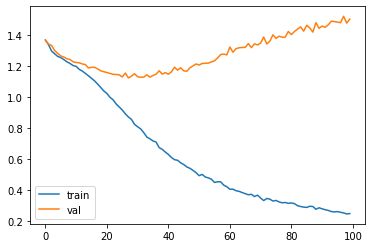

In [54]:
plt.plot(all_train_loss)
plt.plot(all_val_loss)
plt.legend(['train', 'val'])

In [55]:
datatestiter = iter(testloader)
input_test, labels_test = datatestiter.next()
input_test = input_test.to(device)
labels_test = labels_test.to(device)
model.eval()
output_test = model(input_test)
_, preds = torch.max(output_test, 1)
print(preds.shape)
print(labels_test.shape)
print('preds',preds[0:8])
print('labels', labels_test[0:8])
print(torch.sum(preds == labels_test) / len(labels_test))

torch.Size([128])
torch.Size([128])
preds tensor([1, 3, 2, 0, 3, 1, 3, 3], device='cuda:0')
labels tensor([0., 1., 2., 2., 0., 1., 3., 3.], device='cuda:0')
tensor(0.5156, device='cuda:0')
